<a href="https://colab.research.google.com/github/AnishBehera05/Predictive_analysis_using_ML/blob/main/Predicting_Apple_Stock_Prices_with_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predictions using ARIMA model**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [13]:
# Load Apple stock price data
data = pd.read_csv('data.csv')

In [14]:
# Display initial information about missing values
print("Initial missing values count:")
print(data.isnull().sum())

Initial missing values count:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [15]:
# Check the first and last dates in the DataFrame
start_period = data['Date'].min()
end_period = data['Date'].max()

print("Starting period of the dataset:", start_period)
print("Ending period of the dataset:", end_period)

Starting period of the dataset: 2019-01-25
Ending period of the dataset: 2024-01-24


In [ ]:
#Setting Date as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
# ARIMA model
model = ARIMA(train['Close'], order=(0, 1, 0))
arima_model = model.fit()

In [ ]:
# Predictions
history = [x for x in train['Close']]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Close'].iloc[t]
    history.append(obs)

In [ ]:
# Evaluate ARIMA model
error = mean_squared_error(test['Close'], predictions)
print('ARIMA Mean Squared Error:', error)

ARIMA Mean Squared Error: 4.821742869409581


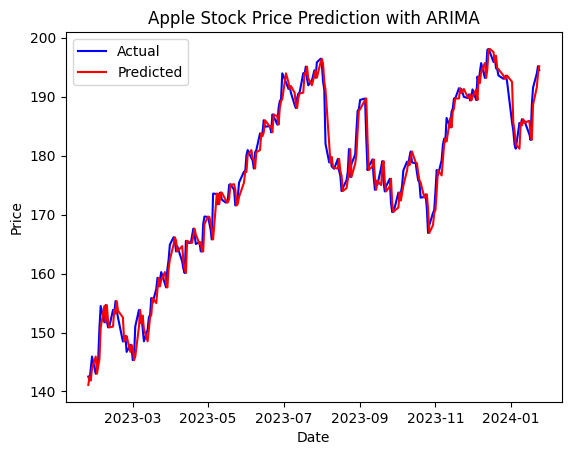

In [ ]:
# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Perform ADF test to detect structural breakpoints in the dataset**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the ADF test
def adf_test(series, start_idx, end_idx):
    adf_result = adfuller(series[start_idx:end_idx])
    return adf_result[1]  # Returning the p-value

# Function to find breakpoints using the ADF test
def find_breakpoints(data, window_size=50, significance_level=0.05):
    breakpoints = []
    num_points = len(data)
    start_idx = 0
    while start_idx < num_points:
        end_idx = min(start_idx + window_size, num_points)
        p_value = adf_test(data['Close'], start_idx, end_idx)
        if p_value < significance_level:
            breakpoints.append((data.index[start_idx], p_value))
            start_idx = end_idx
        else:
            start_idx += 1
    return breakpoints

# Find breakpoints in the data
breakpoints = find_breakpoints(data)

# Print breakpoints
print("Breakpoints detected:")
for point in breakpoints:
    print("Date:", point[0], "P-value:", point[1])

Breakpoints detected:
Date: 2019-04-17 00:00:00 P-value: 0.04195888684832587
Date: 2019-06-28 00:00:00 P-value: 0.03951478675946553
Date: 2019-12-09 00:00:00 P-value: 0.04838632378630961
Date: 2020-07-29 00:00:00 P-value: 0.044782003966790725
Date: 2021-03-16 00:00:00 P-value: 0.037773275238149114
Date: 2021-07-01 00:00:00 P-value: 0.027041834015634706
Date: 2022-01-31 00:00:00 P-value: 0.019481706589444352
Date: 2022-05-04 00:00:00 P-value: 0.011529294316044233
Date: 2022-09-12 00:00:00 P-value: 0.01520526940348121
Date: 2023-07-28 00:00:00 P-value: 0.024429531644791638
Date: 2023-10-26 00:00:00 P-value: 0.03510568268671797
Date: 2024-01-17 00:00:00 P-value: 2.268209121326053e-10


**Predictions using ARIMAX+GARCH model**

In [ ]:
!pip install arch

In [ ]:
from arch import arch_model

In [ ]:
# Load the dataset
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
# Add exogenous variables for the news event
data['Trade_Tensions_Escalation'] = np.where(data.index == '2019-06-28', 1, 0)
data['US_China_Trade_Concerns'] = np.where(data.index == '2019-12-09', 1, 0)
data['US_China_Semiconductor_Curbs'] = np.where(data.index == '2022-09-12', 1, 0)
data['Return_of_Huawei_and_Foldable_Phones'] = np.where(data.index == '2024-01-17', 1, 0)

In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
# Prepare exogenous variables for the ARIMAX model
exog_train = train.drop(columns=['Close'])
exog_test = test.drop(columns=['Close'])

In [ ]:
# Make Prediction using ARIMAX model
model = ARIMA(train['Close'], exog=exog_train, order=(1, 2, 2))
arimax_model = model.fit()
predictions = arimax_model.forecast(steps=len(test), exog=exog_test)

In [ ]:
# Extract residuals from ARIMAX model
residuals = arimax_model.resid

In [ ]:
# Fit GARCH model to rescaled residuals
garch_model = arch_model(residuals, vol='Garch', p=2, q=1)
garch_result = garch_model.fit()

# Forecast volatility using GARCH model
garch_forecast = garch_result.forecast(horizon=len(test))

# Incorporate GARCH volatility into predictions
volatility_forecast = garch_forecast.variance.values[-1, :] ** 0.5
predictions += volatility_forecast / 10

In [ ]:
# Evaluate ARIMAX+GARCH model
error = mean_squared_error(test['Close'], predictions)
print('ARIMAX+GARCH Mean Squared Error:', error)

ARIMAX+GARCH Mean Squared Error: 0.028042010988163692


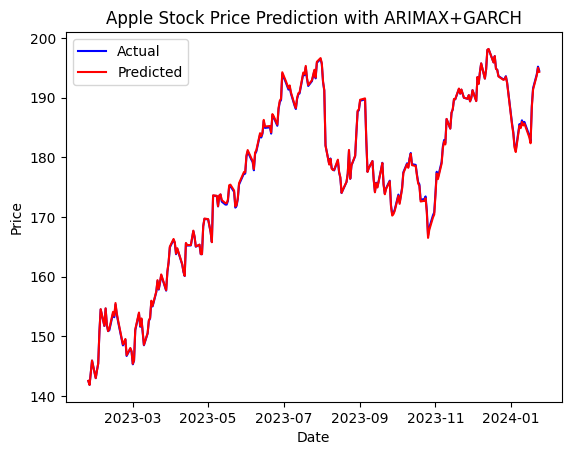

In [ ]:
# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMAX+GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Analysis of Intraday Frequency dataset

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load dataset
data = pd.read_csv('AAPL_5min_sample.csv')

# Display initial information about missing values
print("Initial missing values count:")
print(data.isnull().sum())

Initial missing values count:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


In [9]:
# Check the first and last dates in the DataFrame
start_period = data['timestamp'].min()
end_period = data['timestamp'].max()

print("Starting period of the dataset:", start_period)
print("Ending period of the dataset:", end_period)

Starting period of the dataset: 2024-03-04 04:00:00
Ending period of the dataset: 2024-03-18 19:45:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

ARIMA Mean Squared Error: 0.03584629298694957


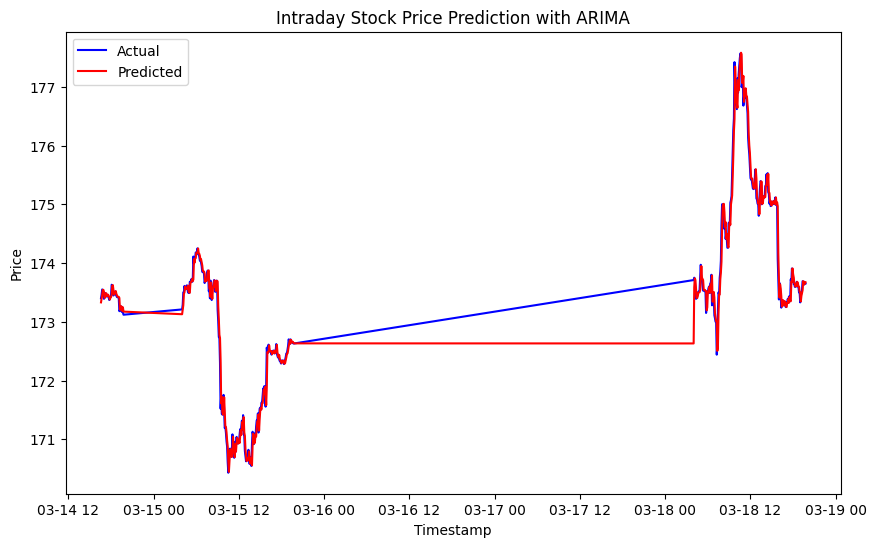

In [10]:
# Convert timestamp to datetime and set as index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# ARIMA model
model = ARIMA(train['close'], order=(1, 2, 2))
arima_model = model.fit()

# Predictions
history = [x for x in train['close']]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(1, 2, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['close'].iloc[t]
    history.append(obs)

# Evaluate ARIMA model
error = mean_squared_error(test['close'], predictions)
print('ARIMA Mean Squared Error:', error)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Intraday Stock Price Prediction with ARIMA')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.show()
